# Analysis

## Prerequisites

In [2]:
import optuna
import pandas as pd

In [204]:
import optuna

import argparse
import logging
import os
from os import PathLike
from typing import Any, Dict, List, Optional, Union
import warnings

import torch
import torch.distributed as dist
import torch.multiprocessing as mp


from allennlp.commands.subcommand import Subcommand
from allennlp.common import Params, Registrable, Lazy
from allennlp.common.checks import check_for_gpu, ConfigurationError
from allennlp.common.meta import Meta, META_NAME
from allennlp.common import logging as common_logging
from allennlp.common import util as common_util
from allennlp.common.plugins import import_plugins
from allennlp.data import DatasetReader, Vocabulary
from allennlp.data import DataLoader
from allennlp.models.archival import archive_model, CONFIG_NAME, verify_include_in_archive
from allennlp.models.model import Model
from allennlp.nn.parallel import DdpAccelerator
from allennlp.training.trainer import Trainer
from allennlp.training import util as training_util

from allennlp.common import FromParams

from optuna import TrialPruned

CONFIG_FILENAME = "transformer_classifier.jsonnet"
MAX_NUMBER_PARAMETERS = 10000000

class DummyTrainCommand(FromParams):
  def __init__(
      self,
      dataset_reader: DatasetReader,
      train_data_path: Any,
      model: Lazy[Model],
      data_loader: Lazy[DataLoader],
      trainer: Lazy[Trainer],
      vocabulary: Lazy[Vocabulary] = Lazy(Vocabulary),
      local_rank: int = 0,
      serialization_dir: str = "",
      datasets_for_vocab_creation: List[str] = None,
      validation_dataset_reader: DatasetReader = None,
      validation_data_path: Any = None,
      validation_data_loader: Lazy[DataLoader] = None,
      test_data_path: Any = None,
      evaluate_on_test: bool = False,
      batch_weight_key: str = "",
      ddp_accelerator: Optional[DdpAccelerator] = None,
      numpy_seed: int = 0,
      pytorch_seed: int = 0,
      random_seed: int = 0,
  ) -> None:
    vocabulary_ = vocabulary.construct()

    model_ = model.construct(
        vocab=vocabulary_, serialization_dir=serialization_dir, ddp_accelerator=ddp_accelerator
    )

    self.model = model_

def get_total_number_params(config_file, **kwargs):
  params = Params.from_file(config_file, ext_vars=kwargs)
  dt = DummyTrainCommand.from_params(params)
  total_params = sum(p.numel() for p in dt.model.parameters() if p.requires_grad)
  return total_params


def get_total_number_adder(config_file):
    def total_number(row) -> float:
        embedding_dim = row["params_embedding_dim"]
        hidden_layers = row["params_hidden_layers"]

        num_total_params = get_total_number_params(config_file, 
                                                embedding_dim=str(embedding_dim),
                                                hidden_layers=str(hidden_layers))

        return num_total_params
    
    return total_number

def get_cnn_total_number_adder(config_file):
    def total_number(row) -> float:
        embedding_dim = row["params_embedding_dim"]
        hidden_layers = row["params_hidden_layers"]
        kernel_size = row["params_kernel_size"]

        num_total_params = get_total_number_params(config_file, 
                                                embedding_dim=str(embedding_dim),
                                                hidden_layers=str(hidden_layers),
                                                kernel_size=str(kernel_size))

        return num_total_params
    
    return total_number

import json
def get_add_metrics_fn(metrics_dir):
    def add_metrics(row) -> Dict:
        exp_id = row["number"]
        metrics = {}
        with open(os.path.join(metrics_dir, str(exp_id), "metrics.json")) as f:
            metrics.update(json.load(f))
        
        return pd.Series(metrics)
    return add_metrics

In [105]:
def load_tf_df():
    root_dir = "optuna_tr"
    study = optuna.create_study(
            storage=f"sqlite:///{root_dir}/trial.db",  # save results in DB
            study_name="optuna_allennlp_tr",
            load_if_exists=True,
            direction="maximize"
    )
    df = study.trials_dataframe()
    add_num_params = get_total_number_adder("transformer_classifier.jsonnet")
    df["num_params"] = df.apply (lambda row: add_num_params(row), axis=1)
    df = df[df["state"]=="COMPLETE"]
    add_metrics_fn = get_add_metrics_fn("optuna_tr")
    df = df.join(df.apply(add_metrics_fn, axis="columns"))

    df = df[df["num_params"] < 80643204]

    with open("tmp_huge/metrics.json") as f:
        extra_metric = json.load(f)

    df = df.append({
            "number": 7,
            "params_embedding_dim": 928,
            "params_hidden_layers": 6,
            "state": "COMPLETE",
            "num_params": get_total_number_params("transformer_classifier.jsonnet", hidden_layers="6", embedding_dim="928"),
            **extra_metric
    }, ignore_index=True)

    return df

tf_df = load_tf_df()

[I 2021-12-20 11:42:59,076] Using an existing study with name 'optuna_allennlp_tr' instead of creating a new one.


In [107]:
from pathlib import Path
def load_lstm_df():
    root_dir = "optuna"
    study_name = "optuna_allennlp"
    study = optuna.create_study(
            storage=f"sqlite:///{root_dir}/trial.db",  # save results in DB
            study_name=study_name,
            load_if_exists=True,
            direction="maximize"
    )
    df = study.trials_dataframe()
    add_num_params = get_total_number_adder("lstm_classifier.jsonnet")
    df["num_params"] = df.apply (lambda row: add_num_params(row), axis=1)
    df = df[df["state"]=="COMPLETE"]
    add_metrics_fn = get_add_metrics_fn("optuna")
    df = df.join(df.apply(add_metrics_fn, axis="columns"))

    extra_dir = Path("extra")
    for ed in extra_dir.iterdir():
        exp_config = json.load(open(ed / "config.json"))

        hid_lyr = exp_config["model"]["seq2vec_encoder"]["num_layers"]
        emd_dim = exp_config["model"]["seq2vec_encoder"]["hidden_size"]

        metrics = json.load(open(ed/"metrics.json"))

        num_params = get_total_number_params("lstm_classifier.jsonnet", 
            hidden_layers=str(hid_lyr), embedding_dim=str(emd_dim))

        df = df.append({
            "params_embedding_dim": emd_dim,
            "params_hidden_layers": hid_lyr,
            "state": "COMPLETE",
            "num_params": num_params,
            **metrics
        }, ignore_index=True)

    return df

lstm_df = load_lstm_df()

[I 2021-12-20 11:44:24,881] Using an existing study with name 'optuna_allennlp' instead of creating a new one.


In [209]:
%cd ..

/home/mila/a/amirhossein.kazemnejad/codes/comp-550-project


In [210]:
from pathlib import Path

def load_cnn_df():
    root_dir = "final_code_base/optuna/agnews/cnn"
    study_name = "optuna_agnews_cnn"
    study = optuna.create_study(
            storage=f"sqlite:///{root_dir}/trial.db",  # save results in DB
            study_name=study_name,
            load_if_exists=True,
            direction="maximize"
    )
    df = study.trials_dataframe()
    %cd final_code_base
    add_num_params = get_cnn_total_number_adder("training_config/cnn_on_agnews.jsonnet")
    df["num_params"] = df.apply (lambda row: add_num_params(row), axis=1)
    %cd ..
    df = df[df["state"]=="COMPLETE"]
    add_metrics_fn = get_add_metrics_fn(root_dir)
    df = df.join(df.apply(add_metrics_fn, axis="columns"))

    return df

cnn_df = load_cnn_df()

[I 2021-12-20 15:10:49,159] Using an existing study with name 'optuna_agnews_cnn' instead of creating a new one.


/home/mila/a/amirhossein.kazemnejad/codes/comp-550-project/final_code_base
/home/mila/a/amirhossein.kazemnejad/codes/comp-550-project


## Plots

In [144]:
def create_plot_data(tdf, target_metric="test_accuracy",thr = 0.1,MAX_PARAMS=1e8, max_steps=12, steps=0.1):
    coeffs = [steps+i*steps for i in range(0, max_steps)]
    x = []
    y = []
    for c in coeffs:
        target_num_params = MAX_PARAMS*c
        masked = tdf[(tdf["num_params"]<=target_num_params*(1+thr))&(tdf["num_params"]>=target_num_params*(1-thr))]
        if masked.shape[0] == 0:
            continue

        # print(c, masked.shape[0])
        # print(masked["best_validation_accuracy"].argmax())
        best_model = masked.iloc[masked["best_validation_accuracy"].argmax()]
        x.append(target_num_params)
        y.append(best_model[target_metric])
    
    return x,y

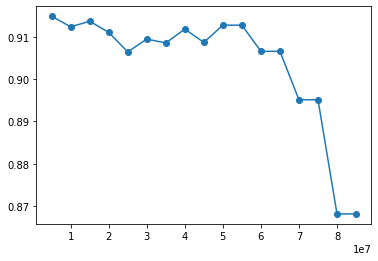

In [166]:
# Test accuracy vs number of parmeters
from matplotlib import pyplot as plt
plt.plot(*create_plot_data(tf_df, thr=0.1, max_steps=26, steps=0.05), '-o')
plt.savefig('.pdf')

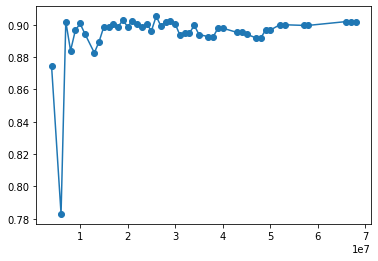

In [217]:
# Test accuracy vs number of parmeters
from matplotlib import pyplot as plt
thr=0.02
plt.plot(*create_plot_data(cnn_df, thr=thr, max_steps=200, steps=0.01), '-o', label="CNN")
plt.savefig('.pdf')

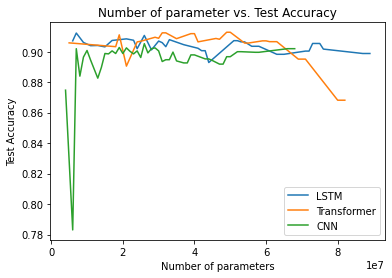

In [223]:
# Test accuracy vs number of parmeters
from matplotlib import pyplot as plt

thr=0.02
plt.plot(*create_plot_data(lstm_df[(lstm_df["num_params"]<0.9*1e8)], thr=thr, max_steps=200, steps=0.01), '-', label="LSTM")
plt.plot(*create_plot_data(tf_df, thr=thr, max_steps=200, steps=0.01), '-', label="Transformer")
plt.plot(*create_plot_data(cnn_df, thr=thr, max_steps=200, steps=0.01), '-', label="CNN")
plt.xlabel("Number of parameters")
plt.ylabel("Test Accuracy")
plt.legend(loc="lower right")
plt.title("Number of parameter vs. Test Accuracy")
plt.savefig('test_vs_num_params.pdf')  

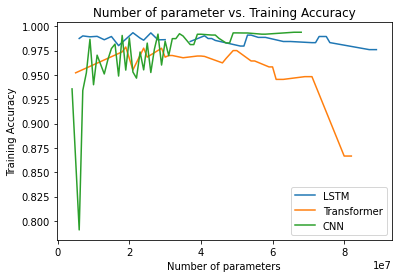

In [224]:
# Test accuracy vs number of parmeters
from matplotlib import pyplot as plt

thr=0.02
report="training_accuracy"
plt.plot(*create_plot_data(lstm_df[(lstm_df["num_params"]<0.9*1e8)], thr=thr, max_steps=200, steps=0.01,target_metric=report), '-', label="LSTM")
plt.plot(*create_plot_data(tf_df, thr=thr, max_steps=200, steps=0.01,target_metric=report), '-', label="Transformer")
plt.plot(*create_plot_data(cnn_df, thr=thr, max_steps=200, steps=0.01,target_metric=report), '-', label="CNN")
plt.xlabel("Number of parameters")
plt.ylabel("Training Accuracy")
plt.legend(loc="lower right")
plt.title("Number of parameter vs. Training Accuracy")
plt.savefig('train_vs_num_params.pdf')  

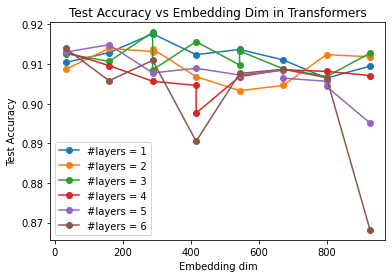

In [199]:
tdf = tf_df
all_hidden_layers = tdf["params_hidden_layers"].unique()
all_embedding_dims = tdf["params_embedding_dim"].unique()
all_hidden_layers.sort()
all_embedding_dims.sort()

metric = "test_accuracy"

for h in all_hidden_layers:
    data = tdf[(tdf["params_hidden_layers"] == h)].sort_values(["params_embedding_dim"])
    x = data["params_embedding_dim"]
    y = data[metric]
    plt.plot(x,y, '-o', label=f"#layers = {h}")

plt.xlabel("Embedding dim")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Embedding Dim in Transformers")
plt.legend(loc="lower left")
plt.savefig('tf_test_acc_vs_embedding_dim.pdf')

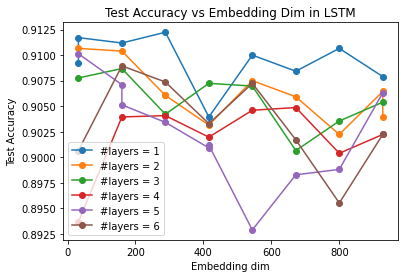

In [200]:
tdf = lstm_df
all_hidden_layers = tdf["params_hidden_layers"].unique()
all_embedding_dims = tdf["params_embedding_dim"].unique()
all_hidden_layers.sort()
all_embedding_dims.sort()

metric = "test_accuracy"

for h in all_hidden_layers:
    data = tdf[(tdf["params_hidden_layers"] == h)].sort_values(["params_embedding_dim"])
    x = data["params_embedding_dim"]
    y = data[metric]
    plt.plot(x,y, '-o', label=f"#layers = {h}")

plt.xlabel("Embedding dim")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Embedding Dim in LSTM")
plt.legend(loc="lower left")
plt.savefig('lstm_test_acc_vs_embedding_dim.pdf')

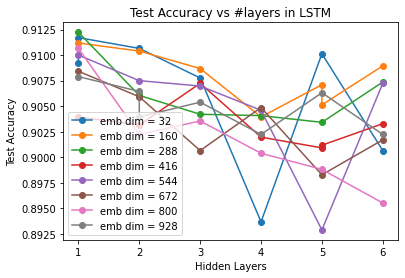

In [234]:
tdf = lstm_df
all_hidden_layers = tdf["params_hidden_layers"].unique()
all_embedding_dims = tdf["params_embedding_dim"].unique()
all_hidden_layers.sort()
all_embedding_dims.sort()

metric = "test_accuracy"

for d in all_embedding_dims:
    data = tdf[(tdf["params_embedding_dim"] == d)].sort_values(["params_hidden_layers"])
    x = data["params_hidden_layers"]
    y = data[metric]
    plt.plot(x,y, '-o', label=f"emb dim = {d}")

plt.xlabel("Hidden Layers")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs #layers in LSTM")
plt.legend(loc="lower left")
plt.savefig('lstm_test_acc_vs_hidden_layers.pdf')

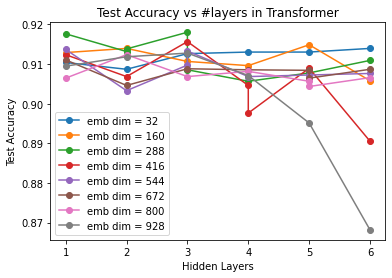

In [233]:
tdf = tf_df
all_hidden_layers = tdf["params_hidden_layers"].unique()
all_embedding_dims = tdf["params_embedding_dim"].unique()
all_hidden_layers.sort()
all_embedding_dims.sort()

metric = "test_accuracy"

for d in all_embedding_dims:
    data = tdf[(tdf["params_embedding_dim"] == d)].sort_values(["params_hidden_layers"])
    x = data["params_hidden_layers"]
    y = data[metric]
    plt.plot(x,y, '-o', label=f"emb dim = {d}")

plt.xlabel("Hidden Layers")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs #layers in Transformer")
plt.legend(loc="lower left")
plt.savefig('tf_test_acc_vs_hidden_layers.pdf')

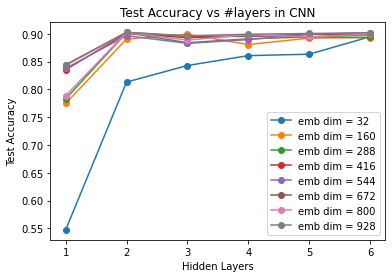

In [231]:
tdf = cnn_df
all_hidden_layers = tdf["params_hidden_layers"].unique()
all_embedding_dims = tdf["params_embedding_dim"].unique()
all_hidden_layers.sort()
all_embedding_dims.sort()

metric = "test_accuracy"

for d in all_embedding_dims:
    # data = tdf[(tdf["params_embedding_dim"] == d)].sort_values(["params_hidden_layers"])
    x = []
    y = []
    for v in all_hidden_layers:
        masked = tdf
        masked = masked[(masked["params_embedding_dim"] == d) & (masked["params_hidden_layers"]==v)]
        if masked.shape[0] == 0:
            print(d, v)
            continue
        best_model = masked.iloc[masked["best_validation_accuracy"].argmax()]
        x.append(v)
        y.append(best_model[metric])

    plt.plot(x,y, '-o', label=f"emb dim = {d}")

plt.xlabel("Hidden Layers")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs #layers in CNN")
plt.legend(loc="lower right")
plt.savefig('cnn_test_acc_vs_hidden_layers.pdf')

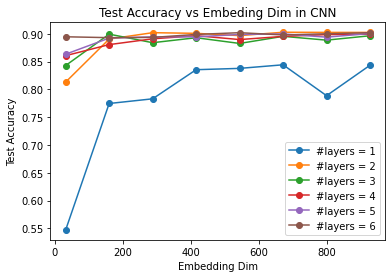

In [244]:
tdf = cnn_df
all_hidden_layers = tdf["params_hidden_layers"].unique()
all_embedding_dims = tdf["params_embedding_dim"].unique()
all_hidden_layers.sort()
all_embedding_dims.sort()

metric = "test_accuracy"

for h in all_hidden_layers:
    # data = tdf[(tdf["params_embedding_dim"] == d)].sort_values(["params_hidden_layers"])
    x = []
    y = []
    for v in all_embedding_dims:
        masked = tdf
        masked = masked[(masked["params_embedding_dim"] == v) & (masked["params_hidden_layers"]==h)]
        if masked.shape[0] == 0:
            print(h, v)
            continue
        best_model = masked.iloc[masked["best_validation_accuracy"].argmax()]
        x.append(v)
        y.append(best_model[metric])

    plt.plot(x,y, '-o', label=f"#layers = {h}")

plt.xlabel("Embedding Dim")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Embeding Dim in CNN")
plt.legend(loc="lower right")
plt.savefig('cnn_test_acc_vs_embd_dim.pdf')

In [178]:
def create_grid_search_table(tdf):
    all_hidden_layers = tdf["params_hidden_layers"].unique()
    all_embedding_dims = tdf["params_embedding_dim"].unique()

    all_hidden_layers.sort()
    all_embedding_dims.sort()

    data = {}
    for h in all_hidden_layers:
        row = []
        for d in all_embedding_dims:
            item = tdf[(tdf["params_embedding_dim"]==d) & (tdf["params_hidden_layers"]==h)].iloc[0]
            row.append(round(item["best_validation_accuracy"]*100, 2))
        
        data[h]=row
    
    return pd.DataFrame.from_dict(data, orient="index", columns=all_embedding_dims)

In [238]:
latex_df = create_grid_search_table(tf_df)
latex_df.to_latex("tf_grid_search_table.tex")
print(latex_df.to_markdown())

|    |    32 |   160 |   288 |   416 |   544 |   672 |   800 |   928 |
|---:|------:|------:|------:|------:|------:|------:|------:|------:|
|  1 | 90.76 | 90.82 | 91    | 90.67 | 91.12 | 90.92 | 90.67 | 90.83 |
|  2 | 90.57 | 91.09 | 91.13 | 90.25 | 89.7  | 89.4  | 90.82 | 90.19 |
|  3 | 91.04 | 90.23 | 91.01 | 90.92 | 89.8  | 90.1  | 90.08 | 90.5  |
|  4 | 91.11 | 91.05 | 89.93 | 90.26 | 89.38 | 90.22 | 89.35 | 89.7  |
|  5 | 90.78 | 90.63 | 89.72 | 89.99 | 88.86 | 89.67 | 89.58 | 88.56 |
|  6 | 90.39 | 89.8  | 90.58 | 87.88 | 89.26 | 90    | 89.71 | 86.62 |


In [243]:
latex_df = create_grid_search_table(lstm_df)
latex_df.to_latex("lstm_grid_search_table.tex")
print(latex_df.to_markdown())

|    |    32 |   160 |   288 |   416 |   544 |   672 |   800 |   928 |
|---:|------:|------:|------:|------:|------:|------:|------:|------:|
|  1 | 90.35 | 90.22 | 90.61 | 90.28 | 90.56 | 90.2  | 90.22 | 89.83 |
|  2 | 90.5  | 90.3  | 90.41 | 90.28 | 90.04 | 89.92 | 89.9  | 89.78 |
|  3 | 89.99 | 90.4  | 90.01 | 90.17 | 90.08 | 89.95 | 89.66 | 90.24 |
|  4 | 88.93 | 90.04 | 89.79 | 89.41 | 89.98 | 89.71 | 89.45 | 89.99 |
|  5 | 89.89 | 90.43 | 89.61 | 89.57 | 89.68 | 89.48 | 89.56 | 89.59 |
|  6 | 89.32 | 90.77 | 89.61 | 90.09 | 90.09 | 89.95 | 89.6  | 89.05 |


In [242]:
def create_grid_search_table_cnn(tdf):
    all_hidden_layers = tdf["params_hidden_layers"].unique()
    all_embedding_dims = tdf["params_embedding_dim"].unique()

    all_hidden_layers.sort()
    all_embedding_dims.sort()

    data = {}
    for h in all_hidden_layers:
        row = []
        for d in all_embedding_dims:
            item = tdf[(tdf["params_embedding_dim"]==d) & (tdf["params_hidden_layers"]==h)]["best_validation_accuracy"].argmax()
            item = tdf[(tdf["params_embedding_dim"]==d) & (tdf["params_hidden_layers"]==h)].iloc[item]
            row.append(round(item["best_validation_accuracy"]*100, 2))
        
        data[h]=row
    
    return pd.DataFrame.from_dict(data, orient="index", columns=all_embedding_dims)

latex_df = create_grid_search_table_cnn(cnn_df)
latex_df.to_latex("cnn_grid_search_table.tex")
print(latex_df.to_markdown())

|    |    32 |   160 |   288 |   416 |   544 |   672 |   800 |   928 |
|---:|------:|------:|------:|------:|------:|------:|------:|------:|
|  1 | 55.18 | 77.19 | 77.83 | 83.05 | 83.17 | 83.7  | 77.77 | 83.09 |
|  2 | 80.26 | 88.26 | 89.2  | 89.03 | 88.98 | 89.49 | 89.02 | 89.59 |
|  3 | 83    | 89.31 | 86.95 | 87.27 | 86.51 | 87.73 | 87.61 | 88.08 |
|  4 | 84.34 | 86.07 | 87.58 | 88.12 | 87.97 | 87.91 | 88.36 | 88.49 |
|  5 | 85.19 | 87.76 | 88.09 | 88.1  | 88.58 | 88.5  | 88.41 | 88.66 |
|  6 | 88.68 | 87.43 | 88.17 | 88.42 | 88.74 | 88.62 | 88.89 | 89.27 |


In [250]:
lstm_df["num_params"].min(),lstm_df[(lstm_df["num_params"]<0.9*1e8)]["num_params"].max()

(657220, 87752004)

In [247]:
tf_df["num_params"].min(),tf_df["num_params"].max()

(652900, 80643204)

In [246]:
cnn_df["num_params"].min(),cnn_df["num_params"].max()

(677956, 66887012)